# 1 Neural Networks Learning

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils


# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
#  training data stored in arrays X, y
data = loadmat('ex4data1.mat')
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

In [4]:
X.shape

(5000, 400)

## 1.1 Visualizing the data

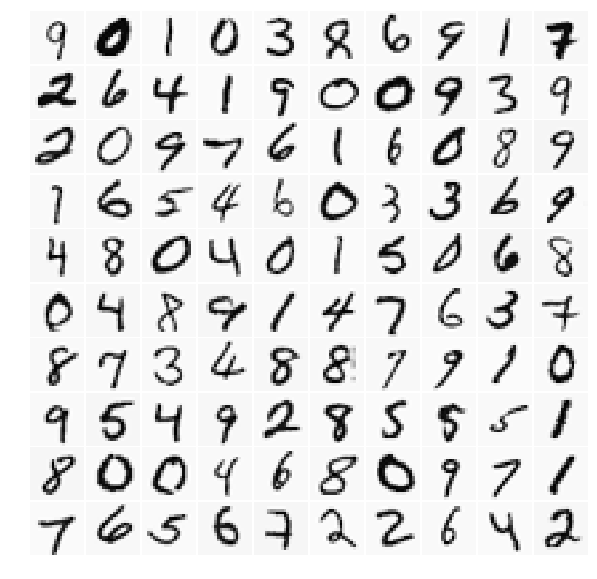

In [5]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

## 1.2 Model representation

In [6]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat('ex4weights.mat')

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

In [7]:
nn_params.shape, Theta1.shape, Theta2.shape

((10285,), (25, 401), (10, 26))

In [18]:
y.reshape

(5000,)

## 1.3 Feedforward and cost function

In [21]:
def sigmoidGradient(z):
    return(utils.sigmoid(z)*(1-utils.sigmoid(z)))

In [32]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
    
    y_matrix = pd.get_dummies(y.ravel()).as_matrix()

         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)   
    
    a1 = np.concatenate([np.ones((m,1)),X], axis=1)     # 5000x401
    z2 = Theta1.dot(a1.T)       # 25x401 * 401x5000 = 25x5000
    a2 = np.concatenate([np.ones((m,1)),utils.sigmoid(z2.T)], axis=1)  # 5000x26
    
    z3 = Theta2.dot(a2.T) # 10x26 * 26x5000 = 10x5000 
    a3 = utils.sigmoid(z3) # 10x5000
    
    J = -1*(1/m)*np.sum((np.log(a3.T)*(y_matrix)+np.log(1-a3).T*(1-y_matrix))) + \
        (lambda_/(2*m))*(np.sum(np.square(Theta1[:,1:])) + np.sum(np.square(Theta2[:,1:])))
    
    #theta1 : 25x401, theta2 : 10x26
        
    d3 = a3.T - y_matrix # 5000x10
    d2 = np.dot(Theta2[:,1:].T, d3.T) * sigmoidGradient(z2) # 25x10 *10x5000 * 25x5000 = 25x5000
    
    delta1 = d2.dot(a1) # 25x5000 * 5000x401 = 25x401
    delta2 = d3.T.dot(a2) # 10x5000 *5000x26 = 10x26
    
    theta1_tmp = np.concatenate([np.ones((Theta1.shape[0],1)),Theta1[:,1:]], axis=1)
    theta2_tmp = np.concatenate([np.ones((Theta2.shape[0],1)),Theta2[:,1:]], axis=1)
    
    Theta1_grad = delta1/m + (theta1_tmp*lambda_)/m
    Theta2_grad = delta2/m + (theta2_tmp*lambda_)/m
    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad
    

In [33]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')


Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# 2 Backpropogation

## 2.1 SigmoidGradient

In [34]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## 2.2 Random Initialization

In [35]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    W = np.zeros((L_out, 1 + L_in))
    
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init
    
    return W

In [36]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)


Initializing Neural Network Parameters ...


## 2.3 Backpropagation

## 2.4 Gradient checking

In [37]:
utils.checkNNGradients(nnCostFunction)

[[-9.27825235e-03 -9.27825236e-03]
 [-3.04978931e-06 -3.04978914e-06]
 [-1.75060084e-04 -1.75060082e-04]
 [-9.62660640e-05 -9.62660620e-05]
 [ 8.89911959e-03  8.89911960e-03]
 [ 1.42869450e-05  1.42869443e-05]
 [ 2.33146358e-04  2.33146357e-04]
 [ 1.17982666e-04  1.17982666e-04]
 [-8.36010761e-03 -8.36010762e-03]
 [-2.59383093e-05 -2.59383100e-05]
 [-2.87468729e-04 -2.87468729e-04]
 [-1.37149709e-04 -1.37149706e-04]
 [ 7.62813550e-03  7.62813551e-03]
 [ 3.69883257e-05  3.69883234e-05]
 [ 3.35320351e-04  3.35320347e-04]
 [ 1.53247082e-04  1.53247082e-04]
 [-6.74798369e-03 -6.74798370e-03]
 [-4.68759764e-05 -4.68759769e-05]
 [-3.76215585e-04 -3.76215587e-04]
 [-1.66560294e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.64090819e-01  1.64090819e-01]
 [ 1.64567932e-01  1.64567932e-01]
 [ 1.58339334e-01  1.58339334e-01]
 [ 1.51127527e-01  1.51127527e-01]
 [ 1.49568335e-01  1.49568335e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.77867378e-02  5

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## 2.5 Regularized Neural Network

In [38]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

[[-9.27825235e-03  5.90721748e-01]
 [-1.67679797e-02 -1.67679797e-02]
 [-6.01744725e-02 -6.01744725e-02]
 [-1.73704651e-02 -1.73704651e-02]
 [ 8.89911959e-03  6.08899120e-01]
 [ 3.94334829e-02  3.94334829e-02]
 [-3.19612287e-02 -3.19612287e-02]
 [-5.75658668e-02 -5.75658668e-02]
 [-8.36010761e-03  5.91639892e-01]
 [ 5.93355565e-02  5.93355565e-02]
 [ 2.49225535e-02  2.49225535e-02]
 [-4.51963845e-02 -4.51963845e-02]
 [ 7.62813550e-03  6.07628136e-01]
 [ 2.47640974e-02  2.47640974e-02]
 [ 5.97717617e-02  5.97717617e-02]
 [ 9.14587966e-03  9.14587966e-03]
 [-6.74798369e-03  5.93252016e-01]
 [-3.26881426e-02 -3.26881426e-02]
 [ 3.86410548e-02  3.86410548e-02]
 [ 5.46101547e-02  5.46101547e-02]
 [ 3.14544970e-01  9.14544970e-01]
 [ 1.18682669e-01  1.18682669e-01]
 [ 2.03987128e-01  2.03987128e-01]
 [ 1.25698067e-01  1.25698067e-01]
 [ 1.76337550e-01  1.76337550e-01]
 [ 1.32294136e-01  1.32294136e-01]
 [ 1.11056588e-01  7.11056588e-01]
 [ 3.81928689e-05  3.81928696e-05]
 [ 1.17148233e-01  1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## 2.6 Learning parameters using scipy.optimize.mininize

In [49]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 500}

#  You should also try different values of lambda
lambda_ = 7

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [50]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))


Training Set Accuracy: 94.380000
